Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function

This is done with SC.

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function
# This is done with SC.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
np.__version__

'1.19.4'

In [3]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [4]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [5]:
# Set up and run a campaign
def run_campaign(sc_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_sc."
    my_campaign = uq.Campaign(name='Ishigami_sc.')

    # Define parameter space
    params = {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

    # Create an encoder and decoder for SC test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=params, actions=actions)

    # Create the sampler
    vary = {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.SCSampler(vary=vary, polynomial_order=sc_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute().collate()

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, sc_order, my_campaign.get_active_sampler().count

In [6]:
R = {}
for sc_order in range(1, 21):
    R[sc_order] = {}
    (R[sc_order]['results_df'], 
     R[sc_order]['results'], 
     R[sc_order]['times'], 
     R[sc_order]['order'], 
     R[sc_order]['number_of_samples']) = run_campaign(sc_order=sc_order, use_files=False)

Time for phase 1 = 0.034
Number of samples = 8
Time for phase 2 = 0.037
Time for phase 3 = 0.012
Time for phase 4 = 0.004
Time for phase 5 = 0.015
Time for phase 6 = 0.002
Time for phase 1 = 0.019
Number of samples = 27
Time for phase 2 = 0.062
Time for phase 3 = 0.018
Time for phase 4 = 0.004
Time for phase 5 = 0.027
Time for phase 6 = 0.001
Time for phase 1 = 0.013
Number of samples = 64
Time for phase 2 = 0.085
Time for phase 3 = 0.023
Time for phase 4 = 0.003
Time for phase 5 = 0.051
Time for phase 6 = 0.001
Time for phase 1 = 0.012
Number of samples = 125
Time for phase 2 = 0.133
Time for phase 3 = 0.038
Time for phase 4 = 0.005
Time for phase 5 = 0.098
Time for phase 6 = 0.002
Time for phase 1 = 0.012
Number of samples = 216
Time for phase 2 = 0.177
Time for phase 3 = 0.058
Time for phase 4 = 0.006
Time for phase 5 = 0.161
Time for phase 6 = 0.002
Time for phase 1 = 0.013
Number of samples = 343
Time for phase 2 = 0.270
Time for phase 3 = 0.097
Time for phase 4 = 0.008
Time for p

In [7]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [8]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.104850,0.033772,0.036851,0.012303,0.003553,0.015254,0.001543
2,0.131947,0.019448,0.061564,0.017511,0.004147,0.026643,0.001267
3,0.177965,0.013305,0.085150,0.022950,0.003328,0.050990,0.001226
4,0.287924,0.011868,0.132969,0.038178,0.004678,0.097685,0.001593
5,0.416340,0.012197,0.176800,0.057941,0.005861,0.160834,0.002171
6,0.671713,0.013307,0.269797,0.096502,0.007841,0.281024,0.002017
7,0.870595,0.010879,0.283524,0.137106,0.012024,0.422834,0.003121
8,1.207009,0.011255,0.349710,0.172280,0.014594,0.655698,0.002904
9,1.760707,0.011406,0.524713,0.311722,0.019545,0.889118,0.003402
10,2.156460,0.010179,0.573686,0.379456,0.021435,1.166950,0.003679


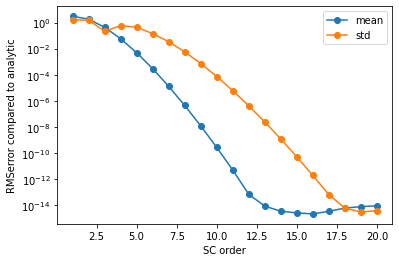

In [9]:
# plot the convergence of the mean and standard deviation to that of the highest order

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('SC order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

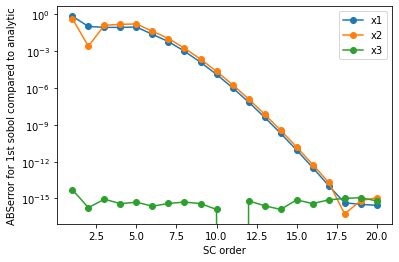

In [10]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('SC order')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

In [11]:
_o = []
_RMS = []
for r in R.values():
    results_df = r['results_df']
    results = r['results']
    Ishigami_surrogate = np.squeeze(np.array(results.surrogate()(results_df[results.inputs])['Ishigami']))
    Ishigami_samples = np.squeeze(np.array(results_df['Ishigami']))
    _RMS.append((np.sqrt((((Ishigami_surrogate - Ishigami_samples))**2).mean())))
    _o.append(r['order'])

In [12]:
Ishigami_surrogate, Ishigami_samples

(array([-0.20338064, -0.18425659, -0.15395212, ...,  0.15934512,
         0.18964959,  0.20877364]),
 array([-0.20338064, -0.18425659, -0.15395212, ...,  0.15934512,
         0.18964959,  0.20877364]))

/Volumes/Samsung8TB/dpc/GIT/EasyVVUQ/env/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:231: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


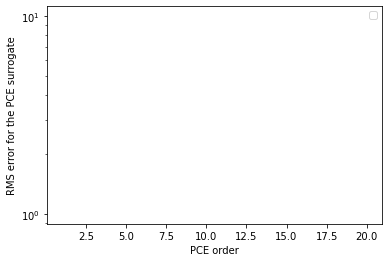

In [13]:
plt.figure()
plt.semilogy(_o, _RMS, 'o-')
plt.xlabel('PCE order')
plt.ylabel('RMS error for the PCE surrogate')
plt.legend(loc=0)
#plt.savefig('Convergence_surrogate.png')
#plt.savefig('Convergence_surrogate.pdf')

In [14]:
I_S_o = np.squeeze(np.array(results.surrogate()(results_df[results.inputs])['Ishigami']))

In [15]:
I_S_d = np.squeeze(results.surrogate_('Ishigami', np.array(results_df[results.inputs])))

In [16]:
I_C = np.squeeze(np.array(results_df['Ishigami']))

In [17]:
np.sqrt(((I_S_d-I_C)**2).mean())

0.0

In [18]:
I_S_o[0:10],I_S_d[0:10], I_C[0:10]

(array([-0.20338064, -0.18425659, -0.15395212, -0.11831839, -0.08359423,
        -0.05480213, -0.03463175, -0.02312928, -0.01824605, -0.01701621]),
 array([-0.20338064, -0.18425659, -0.15395212, -0.11831839, -0.08359423,
        -0.05480213, -0.03463175, -0.02312928, -0.01824605, -0.01701621]),
 array([-0.20338064, -0.18425659, -0.15395212, -0.11831839, -0.08359423,
        -0.05480213, -0.03463175, -0.02312928, -0.01824605, -0.01701621]))